# Alex Liddle
## University of Denver

# Chatbot
A chatbot is an intelligent piece of software that is capable of communicating and performing actions similar to a human. The goal of this project is to build a model that predicts answers using predefined patterns and responses. You are provided with a file named intents.json that contains these patterns. Words and classes files are provided as extra help. Feel free to make a more complex bot by extending the intents file. 

#### Possible chat with your bot
<code>
You: Hello, how are you? 
Bot: Hi there, how can I help?
You: what can you do?
Bot: I can guide you through Adverse drug reaction list, Blood pressure tracking, Hospitals and Pharmacies
You: thanks
Bot: My pleasure
You: see ya. got to go!
Bot: See you
</code>

In [1]:
import nltk
import string
import re
import sklearn
import urllib.request
import requests
import json
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial
#nltk.download('stopwords') #<---uncomment if you haven't downloaded the stopwords library
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load pickle files
classes = pickle.load(urllib.request.urlopen("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/classes.pkl"))
words   = pickle.load(urllib.request.urlopen("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/words.pkl"))
words += ['are', 'can', 'do']#how', 'what', 'you', 'do', 'can']

In [3]:
# Load json file with answer patterns
intents = json.loads(requests.get("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/intents.json").text)

Process patterns for nlp and clustering

In [4]:
df = pd.DataFrame(intents['intents'])
# explode pattern fields into new rows
df_intents = pd.DataFrame({
              col:np.repeat(df[col].values, df['patterns'].str.len())
              for col in df.columns.difference(['patterns'])
          }).assign(**{'patterns':np.concatenate(df['patterns'].values)})[df.columns.tolist()]
# re-add rows with no pattern
df_intents = df_intents.append(pd.DataFrame([{'context':d['context'], 
                                              'patterns':'', 
                                              'responses':d['responses'], 
                                              'tag':d['tag']} 
                                             for d in intents['intents'] if d['patterns']==[]])).reset_index(drop=True)

In [5]:
tqdm.pandas()
stop = stopwords.words()

df_intents['patterns_tfidf'] = [[]]*len(df_intents.patterns.values)
df_intents['patterns_word2vec'] = [[]]*len(df_intents.patterns.values)
df_intents['stemmed_pattern'] = ['']*len(df_intents.patterns.values)
corpus = []
bow_corpus = []

for idx, val in df_intents.patterns.items():
    # Normalize words (i.e., convert to same case)
    lowered = val.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Lemmatize and stem words
    porter = nltk.PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    # make new column for cleaned text
    stemmed_list = simple_preprocess(stemmed)
    df_intents.at[idx, 'patterns_tfidf'] = stemmed
    df_intents.at[idx, 'patterns_word2vec'] = stemmed_list
    corpus.append(TaggedDocument(stemmed_list, [idx]))
    df_intents.at[idx, 'stemmed_pattern'] = ' '.join(stemmed_list)
    for word in stemmed_list:
        bow_corpus.append(word)
    
# Vectorize text
tfidf = TfidfVectorizer(
    min_df = 0,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english', 
)

tfidf.fit(df_intents.patterns_tfidf)
patterns_tfidf = tfidf.transform(df_intents.patterns_tfidf)

df_intents.patterns_tfidf = patterns_tfidf

# Build Word2Vec model
word2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=15, min_count=1, epochs=1000)
word2vec_model.build_vocab(corpus)
word2vec_model.train(corpus, total_examples=word2vec_model.corpus_count, epochs=1000)
wordvectors = word2vec_model.wv
df_intents.patterns_word2vec = df_intents.patterns_word2vec.apply(lambda x: word2vec_model.infer_vector(x))

# Bag of Words
word_freq = {}
for word in bow_corpus:
    if word not in word_freq.keys():
        word_freq[word] = 1
    else:
        word_freq[word] += 1
        
bow_vec = []
for sentence in df_intents.stemmed_pattern:
    sentence_tokens = sentence.split()
    sent_vec = []
    for token in word_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    bow_vec.append(sent_vec)

# remove duplicate patterns
df_intents = df_intents.copy()[:48]
patterns_tfidf = patterns_tfidf.copy()[:48]

df_intents.head()

,tag,patterns,responses,context,patterns_tfidf,patterns_word2vec,stemmed_pattern
0,greeting,Hi there,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-0.8598511, -0.39429143, 0.8774419, -0.166538...",hi there
1,greeting,How are you,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-1.3155255, -0.30250576, -1.6467116, 1.276037...",how are you
2,greeting,Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-1.2581854, -1.1926295, 1.1115643, -0.1223150...",is anyon there
3,greeting,Hey,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.7316129, -0.69045794, -0.9179246, -0.657450...",hey
4,greeting,Hola,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.07950804, 0.67966175, -0.65127814, 1.241009...",hola


In [6]:
def find_optimal_clusters(data, max_k):    
    k_list = range(2, max_k+1)
    
    sse = []
    for k in k_list:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sse.append(MiniBatchKMeans(n_clusters=k, random_state=42).fit(data).inertia_)

    plt.style.use("dark_background")
    f, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.plot(k_list, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(k_list)
    ax.set_xticklabels(k_list)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

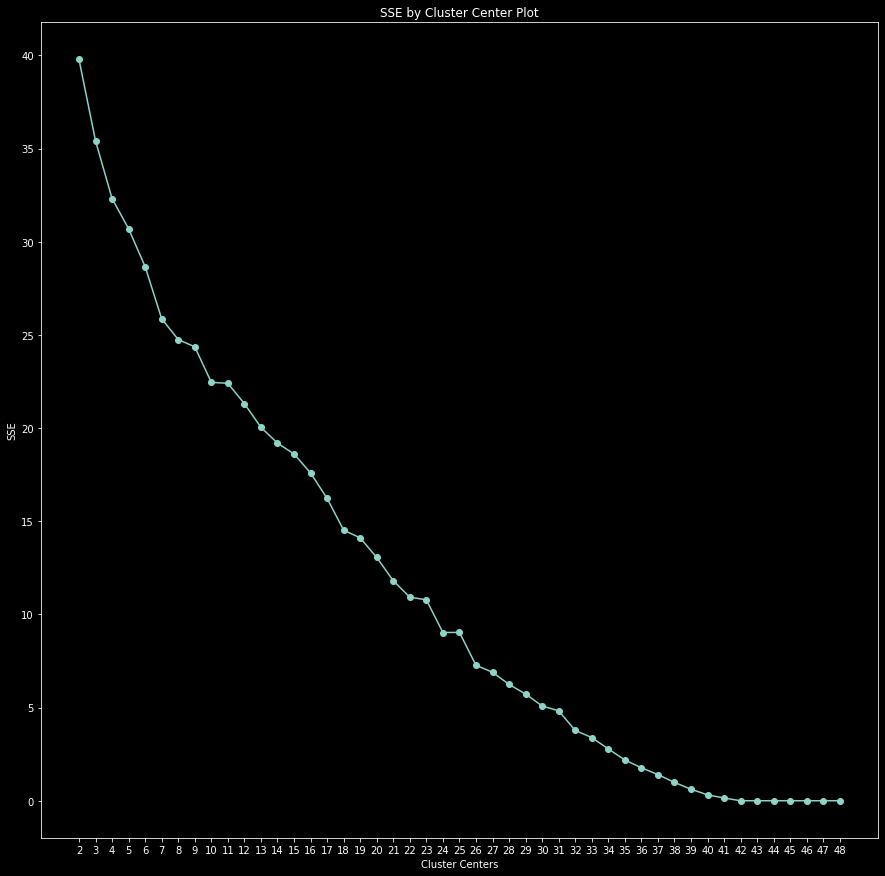

In [7]:
find_optimal_clusters(patterns_tfidf, patterns_tfidf.shape[0])

In [8]:
n_clusters = 42

model = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(patterns_tfidf)

df_intents['patterns_cluster'] = model.predict(patterns_tfidf)
df_intents.head()

,tag,patterns,responses,context,patterns_tfidf,patterns_word2vec,stemmed_pattern,patterns_cluster
0,greeting,Hi there,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-0.8598511, -0.39429143, 0.8774419, -0.166538...",hi there,13
1,greeting,How are you,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-1.3155255, -0.30250576, -1.6467116, 1.276037...",how are you,0
2,greeting,Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[-1.2581854, -1.1926295, 1.1115643, -0.1223150...",is anyon there,19
3,greeting,Hey,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.7316129, -0.69045794, -0.9179246, -0.657450...",hey,15
4,greeting,Hola,"[Hello, thanks for asking, Good to see you aga...",[],"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...","[0.07950804, 0.67966175, -0.65127814, 1.241009...",hola,22


TfidfVector

In [9]:
user_prompt = ''

prompts = df_intents.patterns.values
responses = df_intents.responses.values

i = 0

missed = 0

print('Testing Chatbot')
print('-----------------------')

while True:
    user_prompt = prompts[i] #input("User: ")
    if user_prompt.lower()=='q':
        break
    lowered = user_prompt.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Stem and lemmatize words
    porter = nltk.PorterStemmer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    
    # vectorize
    test_vector = tfidf.transform([stemmed])

    predicted_cluster = model.predict(test_vector)[0]

    response = np.random.choice(list(df_intents[df_intents.patterns_cluster==predicted_cluster].responses)[0])

    if user_prompt == "":
        response = "Sorry, can't understand you"
        
    r = responses[i]
    if response not in r:
        r = r[0]
        missed +=1
    else:
        r = response
    
    print('\nprompt:', user_prompt)
    print('predicted response:', response)
    print('expected response:', r)
        
    i += 1
    if i==len(prompts):
        break

print('-----------------------')
print('\n\nModel Accuracy:',(len(prompts)-missed)/len(prompts))

Testing Chatbot
-----------------------

prompt: Hi there
predicted response: Good to see you again
expected response: Good to see you again

prompt: How are you
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: Is anyone there?
predicted response: Good to see you again
expected response: Good to see you again

prompt: Hey
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: Hola
predicted response: Good to see you again
expected response: Good to see you again

prompt: Hello
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Good day
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Bye
predicted response: See you!
expected response: See you!

prompt: See you later
predicted response: Have a nice day
expected response: Have a nice day

prompt: Goodbye
predicted response: See you!
expected respons

Word2Vec

In [10]:
user_prompt = ''

prompts = df_intents.patterns.values
responses = df_intents.responses.values

i = 0

missed = 0

print('Testing Chatbot')
print('-----------------------')

while True:
    user_prompt = prompts[i] #input("User: ")
    if user_prompt.lower()=='q':
        break
    lowered = user_prompt.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Stem and lemmatize words
    porter = nltk.PorterStemmer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    
    # vectorize
    inferred_vector = word2vec_model.infer_vector(simple_preprocess(stemmed))
    # find similar phrases
    similar = word2vec_model.docvecs.most_similar([inferred_vector])
    similar = ' '.join(corpus[similar[0][0]].words)
    response = np.random.choice(list(df_intents.loc[df_intents.stemmed_pattern==similar]['responses'])[0])
        
    if user_prompt == "":
        response = "Sorry, can't understand you"
    r = responses[i]
    if response not in r:
        r = r[0]
        missed +=1
    else:
        r = response
    
    print('\nprompt:', user_prompt)
    print('predicted response:', response)
    print('expected response:', r)
        
    i += 1
    if i==len(prompts):
        break

print('-----------------------')
print('\n\nModel Accuracy:',(len(prompts)-missed)/len(prompts))

Testing Chatbot
-----------------------

prompt: Hi there
predicted response: Good to see you again
expected response: Good to see you again

prompt: How are you
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: Is anyone there?
predicted response: Good to see you again
expected response: Good to see you again

prompt: Hey
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Hola
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: Hello
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: Good day
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Bye
predicted response: Have a nice day
expected response: Have a nice day

prompt: See you later
predicted response: Have a nice day
expected response: Have a nice day

prompt: Goodbye
predicted response: See y

Bag of Words

In [11]:
user_prompt = ''

prompts = df_intents.patterns.values
responses = df_intents.responses.values

i = 0

missed = 0

print('Testing Chatbot')
print('-----------------------')

while True:
    user_prompt = prompts[i] #input("User: ")
    if user_prompt.lower()=='q':
        break
    lowered = user_prompt.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Stem and lemmatize words
    porter = nltk.PorterStemmer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    
    # vectorize
    sent_vec = []
    sentence_tokens = simple_preprocess(stemmed)
    for token in word_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    
    # find similar phrases
    similar = []
    for vec in bow_vec:
        similar.append(1 - pairwise_distances([vec], [sent_vec], metric = 'cosine')[0][0])
    response = np.random.choice(list(df_intents.loc[np.argmax(similar)]['responses']))
        
    if user_prompt == "":
        response = "Sorry, can't understand you"
    r = responses[i]
    if response not in r:
        r = r[0]
        missed +=1
    else:
        r = response
    
    print('\nprompt:', user_prompt)
    print('predicted response:', response)
    print('expected response:', r)
        
    i += 1
    if i==len(prompts):
        break

print('-----------------------')
print('\n\nModel Accuracy:',(len(prompts)-missed)/len(prompts))

Testing Chatbot
-----------------------

prompt: Hi there
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: How are you
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Is anyone there?
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: Hey
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: Hola
predicted response: Good to see you again
expected response: Good to see you again

prompt: Hello
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Good day
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Bye
predicted response: Bye! Come back again soon.
expected response: Bye! Come back again soon.

prompt: See you later
predicted response: Bye! Come back again soon.
expected response: Bye! Come back ag